## Abstract

This project aims to explore the spatio-temporal dynamics of HIV spread across different countries in Africa. Utilizing a unique blend of spatial and temporal econometric tools, the project seeks to understand the intricate relationships between HIV cases in these countries.

The primary objective is to construct a weighted graph where each vertex represents a country and edges represent the spatial correlation between HIV cases in those countries. The weight of an edge signifies the strength of correlation, providing a nuanced understanding of the disease's spread. This graph in conjunction with a spacial analysis may be then used to evaluate the validity and therefore improve the neighboring matrix that was created to model the spacial relacionships.

**Postscript:**

The weighted graph, constructed from cross-correlation values, provides a quantitative measure of the relationships between countries' HIV infection rates. While correlation does not imply causation, Vector Autoregression (VAR) models and the Granger causality test can be used to explore potential causal relationships and predictive causality, respectively.

VAR models analyze the time-dependent structure of multiple time series, suggesting possible causal links between the HIV infection rates of different countries. The Granger causality test further investigates these relationships by determining if one time series can forecast another, providing insights into the directional influence between countries' infection rates.

Additionally, the graph can serve as a basis for evaluating and refining the neighboring matrix. Significant correlations, especially when validated by VAR and Granger causality analyses, indicate that the connections between countries are not arbitrary but potentially meaningful. This can lead to an improved neighboring matrix that more accurately reflects the true spatial relationships, enhancing the precision of spatial models.

Also it's important to consider the scale of analysis. While the country-level provides a broad overview, a more nuanced approach, such as regional or local-level analysis, could yield a graph with greater detail and relevance. This finer scale may better capture the intricacies of HIV transmission dynamics, leading to more effective public health interventions.

As a final note it is crucial to acknowledge that the evaluation conducted was based on the raw number of cases. Ideally, for a more accurate modeling, normalized data should be used—particularly because the populations between countries are vastly disparate and have also changed significantly in recent years. For instance, the incidence of HIV/AIDS could be more informatively expressed as new infections per 100,000 people per year, age-normalized, to account for population differences. Unfortunately, such normalized data was not accessible for this analysis, as the article containing the “Incidence of HIV/AIDS, 2021” data was not easily available being locked by another data provider. Future analyses would benefit from incorporating this level of detail to enhance the accuracy and applicability of metodology.

## Importing the data

### HIV data

Data from: https://ourworldindata.org/hiv-aids

In [1]:
import pandas as pd
from st_corr_net.config import PROCESSED_DATA_DIR

2025-09-12 20:35:29.925 | INFO     | st_corr_net.config:<module>:11 - PROJ_ROOT path is: C:\Users\UA\source\repos\st-corr-net


In [2]:
HIV_cases_raw_data = pd.read_csv(PROCESSED_DATA_DIR / "deaths-and-new-cases-of-hiv.csv")

In [3]:
HIV_cases_raw_data.head()

,Entitie,Code,Year,"Current number of cases of hiv/aids, in both sexes aged all ages","Number of new cases of hiv/aids, in both sexes aged all ages","Deaths that are from hiv/aids, in both sexes aged all ages"
0,Afghanistan,AFG,1990,418.36453,87.665596,34.301940
1,Afghanistan,AFG,1991,494.74704,103.773590,40.843838
2,Afghanistan,AFG,1992,609.43040,119.933400,48.379300
3,Afghanistan,AFG,1993,707.02704,127.263300,55.828987
4,Afghanistan,AFG,1994,771.01400,133.063080,63.353203


In [4]:
HIV_cases_raw_data.tail()

,Entitie,Code,Year,"Current number of cases of hiv/aids, in both sexes aged all ages","Number of new cases of hiv/aids, in both sexes aged all ages","Deaths that are from hiv/aids, in both sexes aged all ages"
6775,Zimbabwe,ZWE,2015,1245190.1,47924.895,29161.730
6776,Zimbabwe,ZWE,2016,1242938.4,43866.800,27140.791
6777,Zimbabwe,ZWE,2017,1239271.9,39254.800,24846.238
6778,Zimbabwe,ZWE,2018,1234155.8,34072.930,22106.465
6779,Zimbabwe,ZWE,2019,1227095.8,31509.064,20722.240


The columns names are too detailed; let's simplify them.

In [5]:
HIV_cases_raw_data.columns = ['Entity', 'Code', 'Year',
       'Total cases',
       'New cases',
       'Deaths']

### African continent shape file

Data origin: https://opendata.rcmrd.org/datasets/rcmrd::africa-countries-dataset/about

In [6]:
import geopandas as gpd
from st_corr_net.config import EXTERNAL_DATA_DIR

In [7]:
africa_shape_raw_data = gpd.read_file(EXTERNAL_DATA_DIR / "africa_countries.geojson")

africa_shape_raw_data.head()

,FID,OBJECTID,ISO,NAME_0,Continent,REgion,Shape__Area,Shape__Length,geometry
0,1,1,AGO,Angola,Africa,,1.319276e+12,8.268691e+06,"MULTIPOLYGON (((11.70236 -16.50764, 11.70236 -..."
1,2,2,ATF,French Southern Territories,Africa,,1.821181e+10,5.408334e+06,"MULTIPOLYGON (((68.86333 -50.01889, 68.86166 -..."
2,3,3,BDI,Burundi,Africa,Eastern_Africa,2.723823e+10,1.133305e+06,"POLYGON ((30.41152 -2.31061, 30.41243 -2.3118,..."
3,4,4,BEN,Benin,Africa,,1.196064e+11,2.250046e+06,"MULTIPOLYGON (((1.87042 6.28819, 1.87042 6.287..."
4,5,5,BFA,Burkina Faso,Africa,,2.897278e+11,3.501052e+06,"POLYGON ((-0.45567 15.08082, -0.44206 15.06812..."


<Axes: >

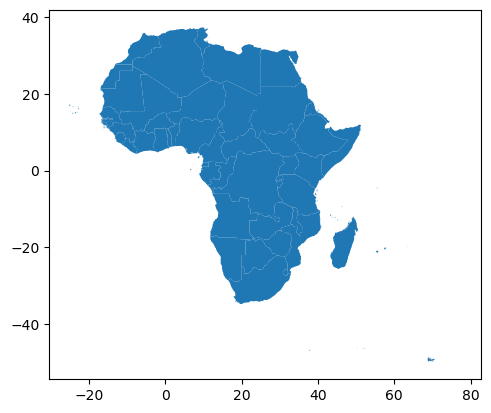

In [8]:
africa_shape_raw_data.plot()

## Data merge

Now we need to merge the HIV data with the african shape file so a spacial analysis can be done

In [9]:
HIV_cases_str_lower_data = HIV_cases_raw_data
africa_shape_str_lower_data = africa_shape_raw_data

# Ensure the country names are in the same format (e.g., all lower case)
HIV_cases_str_lower_data['Entity'] = HIV_cases_raw_data['Entity'].str.lower()
africa_shape_str_lower_data['NAME_0'] = africa_shape_raw_data['NAME_0'].str.lower()

# Merge the datasets
merged_data = HIV_cases_str_lower_data.merge(africa_shape_str_lower_data, left_on='Entity', right_on='NAME_0', how='inner')

# Check the merged data
merged_data.head()

,Entity,Code,Year,Total cases,New cases,Deaths,FID,OBJECTID,ISO,NAME_0,Continent,REgion,Shape__Area,Shape__Length,geometry
0,algeria,DZA,1990,660.46466,124.47287,44.407578,14,14,DZA,algeria,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35..."
1,algeria,DZA,1991,740.80950,135.87650,50.331066,14,14,DZA,algeria,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35..."
2,algeria,DZA,1992,830.14920,158.94077,56.761130,14,14,DZA,algeria,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35..."
3,algeria,DZA,1993,929.47797,172.61952,63.944130,14,14,DZA,algeria,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35..."
4,algeria,DZA,1994,1039.72510,198.84825,71.511730,14,14,DZA,algeria,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35..."


<Axes: >

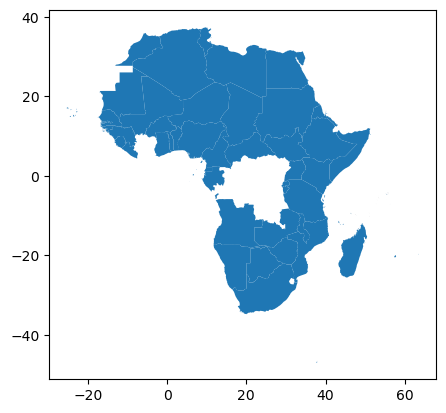

In [10]:
# Ensuring the DataFrame is a GeoDataFrame
merged_data_gpd = gpd.GeoDataFrame(merged_data)

merged_data_gpd_dd = merged_data_gpd.drop_duplicates('geometry')

# Plot the geometries
merged_data_gpd_dd.plot()

In [11]:
# Get the unique country names in the HIV dataset and the shapefile
hiv_countries = set(HIV_cases_raw_data['Entity'].unique())
shape_countries = set(africa_shape_raw_data['NAME_0'].unique())

# Find the countries in the shapefile that are not in the HIV dataset
missing_in_hiv = shape_countries - hiv_countries
print("Countries in the shapefile but not in the HIV dataset: \n\n", missing_in_hiv)


Countries in the shapefile but not in the HIV dataset: 

 {"côte d'ivoire", 'reunion', 'french southern territories', 'swaziland', 'mayotte', 'western sahara', 'republic of congo', 'democratic republic of the congo'}


Some contries are missing. It's because some names aren't exacly equal, let's fix it. 

In [12]:
# Create a dictionary to map the old names to the new names
name_mapping = {
    'democratic republic of the congo': 'democratic republic of congo',
    'republic of congo': 'congo',
    "côte d'ivoire": "cote d'ivoire",
    'swaziland': 'eswatini'
}

# Replace the country names in the shapefile
africa_shape_names_data = africa_shape_str_lower_data
africa_shape_names_data['NAME_0'] = africa_shape_str_lower_data['NAME_0'].replace(name_mapping)

Test the changes

<Axes: >

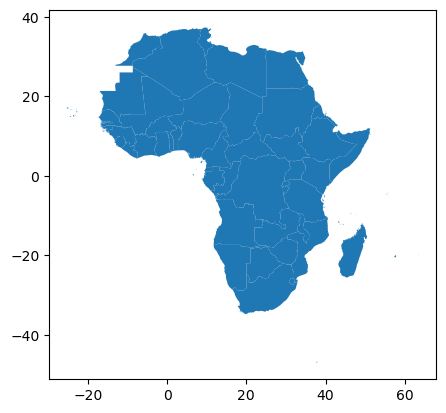

In [13]:
# Merge the datasets
merged_data = HIV_cases_str_lower_data.merge(africa_shape_names_data, left_on='Entity', right_on='NAME_0', how='inner')

# Check the merged data
merged_data

# Ensure your DataFrame is a GeoDataFrame
merged_data_gpd = gpd.GeoDataFrame(merged_data)

merged_data_gpd_dd = merged_data_gpd.drop_duplicates('geometry')

# Plot the geometries
merged_data_gpd_dd.plot()

In [14]:
# Get the unique country names in the HIV dataset and the shapefile
hiv_countries = set(HIV_cases_str_lower_data['Entity'].unique())
shape_countries = set(africa_shape_str_lower_data['NAME_0'].unique())

# Find the countries in the shapefile that are not in the HIV dataset
missing_in_hiv = shape_countries - hiv_countries
print("Countries in the shapefile but not in the HIV dataset:", missing_in_hiv)

Countries in the shapefile but not in the HIV dataset: {'reunion', 'french southern territories', 'western sahara', 'mayotte'}


On these countries there is no data so there is no problem

In [15]:
merged_data_gpd.head()

,Entity,Code,Year,Total cases,New cases,Deaths,FID,OBJECTID,ISO,NAME_0,Continent,REgion,Shape__Area,Shape__Length,geometry
0,algeria,DZA,1990,660.46466,124.47287,44.407578,14,14,DZA,algeria,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35..."
1,algeria,DZA,1991,740.80950,135.87650,50.331066,14,14,DZA,algeria,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35..."
2,algeria,DZA,1992,830.14920,158.94077,56.761130,14,14,DZA,algeria,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35..."
3,algeria,DZA,1993,929.47797,172.61952,63.944130,14,14,DZA,algeria,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35..."
4,algeria,DZA,1994,1039.72510,198.84825,71.511730,14,14,DZA,algeria,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35..."


In [16]:
merged_data_gpd_drop = merged_data_gpd.drop(['FID', 'OBJECTID', 'ISO', 'NAME_0'], axis=1)
merged_data_gpd_dd_drop = merged_data_gpd_dd.drop(['FID', 'OBJECTID', 'ISO', 'NAME_0'], axis=1)

merged_data_gpd_drop.head()

,Entity,Code,Year,Total cases,New cases,Deaths,Continent,REgion,Shape__Area,Shape__Length,geometry
0,algeria,DZA,1990,660.46466,124.47287,44.407578,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35..."
1,algeria,DZA,1991,740.80950,135.87650,50.331066,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35..."
2,algeria,DZA,1992,830.14920,158.94077,56.761130,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35..."
3,algeria,DZA,1993,929.47797,172.61952,63.944130,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35..."
4,algeria,DZA,1994,1039.72510,198.84825,71.511730,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35..."


## Spacial analysis

In [17]:
# Utils
from copy import deepcopy
from itertools import combinations

# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily
import ipywidgets as widgets
from IPython.display import display

# Analysis
import numpy as np
import statsmodels.api as sm
from pysal.explore import esda
from pysal.lib import weights
from libpysal.weights import W
from numpy.random import seed
from esda.moran import Moran
from esda.moran import Moran_Local

# https://splot.readthedocs.io/en/latest/api.html
# pysal.viz »» splot [splot.esda] (tem métodos para esda e outras componentes - ver api)
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster
from splot.esda import plot_moran

c:\Users\UA\miniconda3\envs\st-corr-net\lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


Now we would like to conduct a spacial analysis, before conducting that let's plot the New cases data for the 1990.

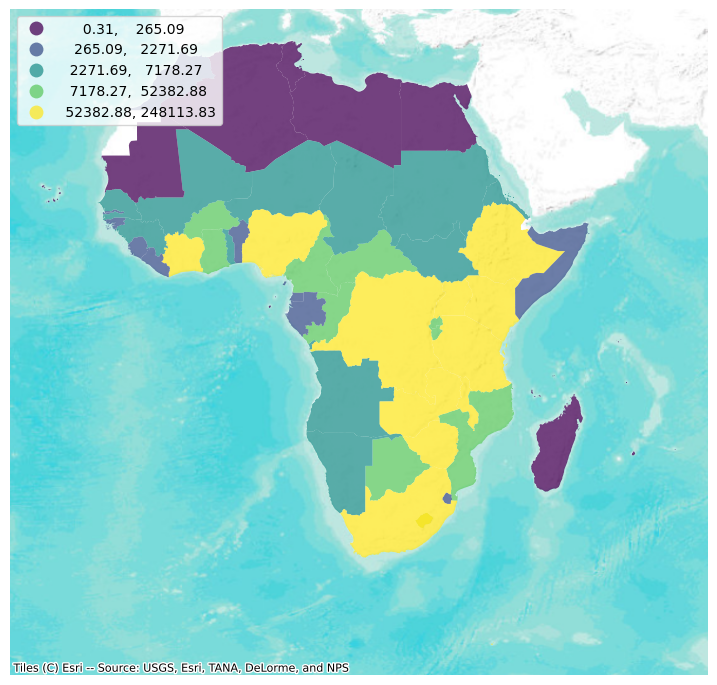

In [18]:
f, ax = plt.subplots(1, figsize=(9, 9))
merged_data_gpd_dd_drop.plot(
    column="New cases",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)

# Addition of basemap, ethernet connection is required
contextily.add_basemap(
    ax,
    crs=merged_data_gpd_dd_drop.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax.set_axis_off()

where we can see that african can be divided geographically by the ammount of new cases of HIV. More specifically the areas that are less affected are the northen and the inslands, followed up by the mid section of the african continent. The worse zone is on the "south" area of african colored by yealow.

### Spacial correlation

Spatial autocorrelation measures the degree to which a spatial attribute is correlated with itself in space. From how the data is formated two main approaches may be made whether the year or the country are fixed to calculate spatial autocorrelation: **time-series analysis** and **cross-sectional analysis**.

#### 1. Cross-Sectional Analysis (By Year)

The global and local Moran index and its p-value are calculated for all countries in a specific year. This is essentially a cross-sectional analysis of spatial autocorrelation. 

This allows:

- Global Moran: Evaluate the spatial distribution of the data and its significance over the years (i.e. random spatial distribution)

- Local Moran: Detect significant spatial clusters over the years and how their number changes over the years. 

This approach provides a global measure of spatial autocorrelation. However, it only provides a general picture of spatial autocorrelation and therefore does not quantitatively capture the strength of the correlation between spatial units.

#### 2. Time-Series Analysis (By Country) with Cross-Correlation

For each country, we calculate the **cross-correlation** of new HIV infection rates with its neighbors over a specified time period (e.g., 1990 to 2019). This method extends the spatial autocorrelation analysis into the temporal domain.

This allows:

- **Cross-Correlation:** To determine the strength and direction of the relationship between the HIV new infections of neighboring countries, and how these relationships evolve over time.
  
- **Time Lags:** To identify potential delays in the spread of HIV, which may indicate the timing and directionality of transmission across borders.

With this approach it will be possible to construct the desired graph and also, with the calculation of the confidence intervals, measure if the connection is statistical significant although this latter part was not done because of time constrain for evaluating if the required assumptions were satisfied (i.e. joint distribution was normal for instance).

For conducting these spacial analysis a spatial weights matrix must first be defined, for the problem at hand the Queen metric was chosen.


In [19]:
# Create a spatial weights matrix
w_Queen = weights.Queen.from_dataframe(merged_data_gpd_dd_drop, use_index=False)


c:\Users\UA\miniconda3\envs\st-corr-net\lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 8 islands with ids: 6, 10, 25, 28, 32, 39, 41, 44.
  W.__init__(self, neighbors, ids=ids, **kw)


It's possible to see that on the data there is 8 islands, printing the names of the countries.

In [20]:
# Extract the unique list of country names from the DataFrame
unique_countries = list(merged_data_gpd_dd_drop['Entity'].unique())

# List of indices for the islands
island_indices = [7, 10, 25, 28, 32, 39, 41, 44]

# Print the names of the countries corresponding to the island indices
island_countries = [unique_countries[index] for index in island_indices]
print("The names of the island countries are: \n", island_countries)


The names of the island countries are: 
 ['cameroon', 'comoros', 'lesotho', 'madagascar', 'mauritius', 'sao tome and principe', 'seychelles', 'south africa']


Ploting the resulting graph

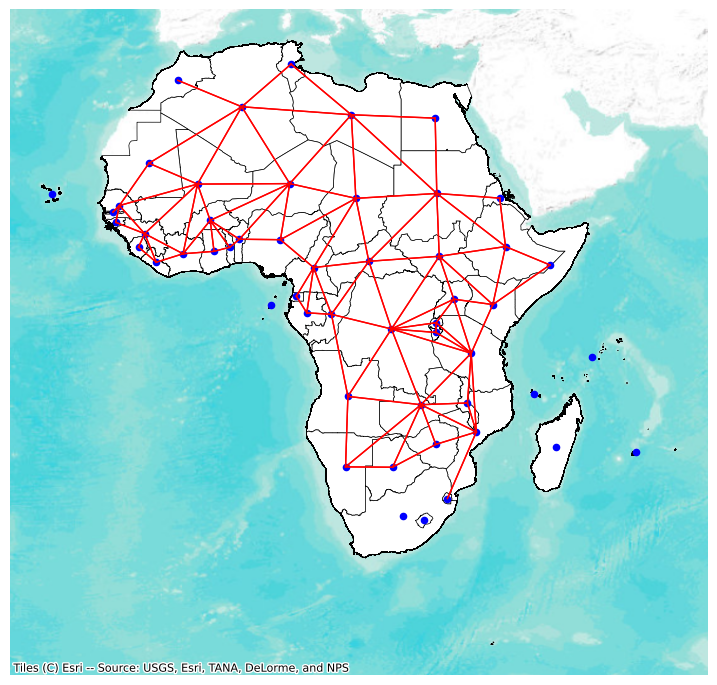

In [21]:
# Plot the geometries without coloring by 'New cases'
f, ax = plt.subplots(1, figsize=(9, 9))
merged_data_gpd_dd_drop.plot(
    color='white', 
    edgecolor='black', 
    linewidth=0.5, 
    ax=ax
)

# Overlay the graph of neighbors with vertices and edges
for index, neighbors in w_Queen.neighbors.items():
    country_geometry = merged_data_gpd_dd_drop.geometry.iloc[index]
    country_centroid = country_geometry.centroid.coords[0]
    
    # Plot the vertex for the country
    plt.scatter(*country_centroid, color='blue', s=20)  # s is the size of the vertex
    
    for neighbor_index in neighbors:
        neighbor_geometry = merged_data_gpd_dd_drop.geometry.iloc[neighbor_index]
        neighbor_centroid = neighbor_geometry.centroid.coords[0]
        
        # Draw an edge between country centroid and neighbor centroid
        plt.plot(
            [country_centroid[0], neighbor_centroid[0]], 
            [country_centroid[1], neighbor_centroid[1]], 
            color='red', 
            linewidth=1
        )
        
        # Plot the vertex for the neighbor
        plt.scatter(*neighbor_centroid, color='blue', s=10)

# Add a basemap for context
contextily.add_basemap(
    ax,
    crs=merged_data_gpd_dd_drop.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax.set_axis_off()

# Show the plot
plt.show()


Looks like South Africa has not set up the neighbours correctly, they must be defined manualy

#### Setting up the South african neighbors manualy

In [22]:
# List of countries that border South Africa
bordering_countries = ['namibia', 'botswana', 'zimbabwe', 'mozambique', 'eswatini', 'lesotho']

# Find the indices for these countries in the GeoDataFrame
bordering_indices = []
for country in bordering_countries:
    country_index = unique_countries.index(country)
    bordering_indices.append(country_index)

# Print the indices of the neighboring countries
print("Indices of South Africa's neighboring countries:", bordering_indices)


Indices of South Africa's neighboring countries: [35, 3, 52, 34, 17, 25]


In [23]:
# First, find the index of South Africa in 'unique_countries'
index_south_africa = unique_countries.index('south africa')

# Copy the adjacency matrix
w_Queen_mod = deepcopy(w_Queen)

# Update the neighbors for South Africa
w_Queen_mod.neighbors[index_south_africa] = bordering_indices

# Update the weights for South Africa to match the number of neighbors
w_Queen_mod.weights[index_south_africa] = [1] * len(bordering_indices)

# Update the neighbors and weights for the neighboring countries
for neighbor_index in bordering_indices:
    # If South Africa is not already in the neighbors list, append it
    if index_south_africa not in w_Queen_mod.neighbors[neighbor_index]:
        w_Queen_mod.neighbors[neighbor_index].append(index_south_africa)
        w_Queen_mod.weights[neighbor_index].append(1)  # Append weight of 1 for the connection
    else:
        # Find the position of South Africa in the neighbors list
        sa_index_in_neighbor = w_Queen_mod.neighbors[neighbor_index].index(index_south_africa)
        # Update the corresponding weight to 1
        w_Queen_mod.weights[neighbor_index][sa_index_in_neighbor] = 1

    # Ensure there are no duplicate indices in the neighbors list
    w_Queen_mod.neighbors[neighbor_index] = list(set(w_Queen_mod.neighbors[neighbor_index]))
    # Ensure weights list matches the neighbors list in length
    w_Queen_mod.weights[neighbor_index] = [1] * len(w_Queen_mod.neighbors[neighbor_index])


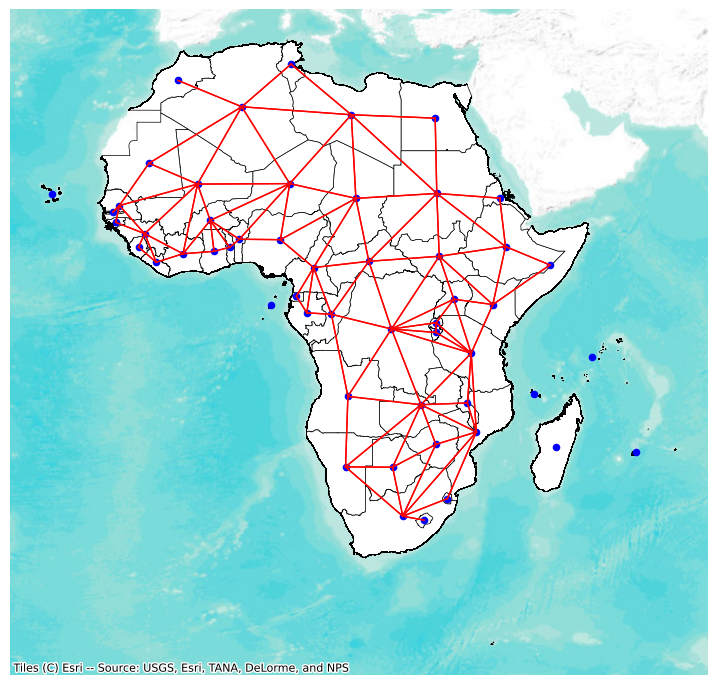

In [24]:
# Plot the geometries without coloring by 'New cases'
f, ax = plt.subplots(1, figsize=(9, 9))
merged_data_gpd_dd_drop.plot(
    color='white', 
    edgecolor='black', 
    linewidth=0.5, 
    ax=ax
)

# Overlay the graph of neighbors with vertices and edges
for index, neighbors in w_Queen_mod.neighbors.items():
    country_geometry = merged_data_gpd_dd_drop.geometry.iloc[index]
    country_centroid = country_geometry.centroid.coords[0]
    
    # Plot the vertex for the country
    plt.scatter(*country_centroid, color='blue', s=20)  # s is the size of the vertex
    
    for neighbor_index in neighbors:
        neighbor_geometry = merged_data_gpd_dd_drop.geometry.iloc[neighbor_index]
        neighbor_centroid = neighbor_geometry.centroid.coords[0]
        
        # Draw an edge between country centroid and neighbor centroid
        plt.plot(
            [country_centroid[0], neighbor_centroid[0]], 
            [country_centroid[1], neighbor_centroid[1]], 
            color='red', 
            linewidth=1
        )
        
        # Plot the vertex for the neighbor
        plt.scatter(*neighbor_centroid, color='blue', s=10)

# Add a basemap for context
contextily.add_basemap(
    ax,
    crs=merged_data_gpd_dd_drop.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax.set_axis_off()

# Show the plot
plt.show()


#### Spliting the data by year and country

Having that let's also subdivide the data by year, this will make it easier to apply the methods

In [25]:
# Create a dictionary to store the dataframes for each year
HIV_data_by_year = {}

# Loop over the unique years in the data
for year in merged_data_gpd_drop['Year'].unique():
    # Select the data for the current year
    HIV_data_year = merged_data_gpd_drop[merged_data_gpd_drop['Year'] == year]
    
    # Store the dataframe in the dictionary
    HIV_data_by_year[year] = HIV_data_year

HIV_data_by_year[2000].head()

,Entity,Code,Year,Total cases,New cases,Deaths,Continent,REgion,Shape__Area,Shape__Length,geometry
10,algeria,DZA,2000,2069.2703,413.72794,123.16436,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35..."
40,angola,AGO,2000,86449.4450,17736.98400,4783.65200,Africa,,1.319276e+12,8.268691e+06,"MULTIPOLYGON (((11.70236 -16.50764, 11.70236 -..."
70,benin,BEN,2000,57743.4600,7123.50440,3828.18300,Africa,,1.196064e+11,2.250046e+06,"MULTIPOLYGON (((1.87042 6.28819, 1.87042 6.287..."
100,botswana,BWA,2000,255227.3300,26228.04100,15884.82700,Africa,,6.785715e+11,4.373780e+06,"POLYGON ((25.21502 -17.79051, 25.24286 -17.792..."
130,burkina faso,BFA,2000,178955.6100,11848.15700,16277.07100,Africa,,2.897278e+11,3.501052e+06,"POLYGON ((-0.45567 15.08082, -0.44206 15.06812..."


Now that the data is divided by year it's possible to compute the standart desviation of the variable `New cases` and it's respective spacial lag value for each year

In [26]:
# "Normalize" (z-scores calculation) of the original and lagged variables
for year in merged_data_gpd['Year'].unique():
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    year_data = HIV_data_by_year[year].copy()
    
    # Calculate New_cases_std
    year_data['New_cases_std'] = (year_data['New cases'] - year_data['New cases'].mean()) / year_data['New cases'].std()
    
    # Calculate New_cases_lag
    year_data["New_cases_lag"] = weights.lag_spatial(w_Queen, year_data["New_cases_std"])
    
    # Calculate New_cases_lag_std
    year_data['New_cases_lag_std'] = (year_data['New_cases_lag'] - year_data['New_cases_lag'].mean()) / year_data['New_cases_lag'].std()
    
    # Update the dictionary with the modified DataFrame
    HIV_data_by_year[year] = year_data

# Display the head of the DataFrame for the year 2000
HIV_data_by_year[2000].head()


,Entity,Code,Year,Total cases,New cases,Deaths,Continent,REgion,Shape__Area,Shape__Length,geometry,New_cases_std,New_cases_lag,New_cases_lag_std
10,algeria,DZA,2000,2069.2703,413.72794,123.16436,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35...",-0.453851,-2.558212,-1.813791
40,angola,AGO,2000,86449.4450,17736.98400,4783.65200,Africa,,1.319276e+12,8.268691e+06,"MULTIPOLYGON (((11.70236 -16.50764, 11.70236 -...",-0.280204,-0.078372,-0.032654
70,benin,BEN,2000,57743.4600,7123.50440,3828.18300,Africa,,1.196064e+11,2.250046e+06,"MULTIPOLYGON (((1.87042 6.28819, 1.87042 6.287...",-0.386592,0.292728,0.233887
100,botswana,BWA,2000,255227.3300,26228.04100,15884.82700,Africa,,6.785715e+11,4.373780e+06,"POLYGON ((25.21502 -17.79051, 25.24286 -17.792...",-0.195090,1.262160,0.930178
130,burkina faso,BFA,2000,178955.6100,11848.15700,16277.07100,Africa,,2.897278e+11,3.501052e+06,"POLYGON ((-0.45567 15.08082, -0.44206 15.06812...",-0.339233,-1.336185,-0.936074


Now with the standart desviation of the variable `New cases` and it's respective spacial lag using the queen metric a concatenation by contrie to retrieve all the data points from 1990 to 2019 will be made

In [27]:
# Create a dictionary to stores the New cases std and it's respective lag for each country for all yearly available data
HIV_data_by_country = {}

for country in merged_data_gpd_dd_drop['Entity']:
    data_country = [HIV_data_by_year[year][HIV_data_by_year[year]['Entity'] == country] for year in merged_data_gpd_drop['Year'].unique()]

    data_country = pd.concat(data_country)
    
    HIV_data_by_country[country] = data_country

HIV_data_by_country['algeria'].head()

,Entity,Code,Year,Total cases,New cases,Deaths,Continent,REgion,Shape__Area,Shape__Length,geometry,New_cases_std,New_cases_lag,New_cases_lag_std
0,algeria,DZA,1990,660.46466,124.47287,44.407578,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35...",-0.560036,-3.208094,-1.341703
1,algeria,DZA,1991,740.80950,135.87650,50.331066,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35...",-0.571484,-3.256404,-1.392352
2,algeria,DZA,1992,830.14920,158.94077,56.761130,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35...",-0.582444,-3.303095,-1.449224
3,algeria,DZA,1993,929.47797,172.61952,63.944130,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35...",-0.587565,-3.317492,-1.515735
4,algeria,DZA,1994,1039.72510,198.84825,71.511730,Africa,,3.001998e+12,9.839386e+06,"MULTIPOLYGON (((-1.63069 35.21958, -1.63069 35...",-0.577605,-3.251536,-1.589148


#### Aplying the 1.º method  

In [28]:
moran_p_values_by_year = []

for year, df in HIV_data_by_year.items():
    y = HIV_data_by_year[year]['New cases']
    w = w_Queen_mod
    moran = Moran(y, w)
    print(f"Moran's I for the year {year}: ({moran.I}, {moran.p_sim})")
    moran_p_values_by_year.append(moran.p_sim)

('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 32, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WARNING: ', 41, ' is an island (no neighbors)')
Moran's I for the year 1990: (0.3179714159358284, 0.006)
Moran's I for the year 1991: (0.2745105297688353, 0.008)
Moran's I for the year 1992: (0.24131083422540708, 0.018)
Moran's I for the year 1993: (0.21760107501860862, 0.018)
Moran's I for the year 1994: (0.19857452315404472, 0.028)
Moran's I for the year 1995: (0.1792264725260724, 0.035)
Moran's I for the year 1996: (0.16006863823356832, 0.042)
Moran's I for the year 1997: (0.14465956182459708, 0.028)
Moran's I for the year 1998: (0.13458425696009554, 0.04)
Moran's I for the year 1999: (0.1294128864467071, 0.035)
Moran's I for the year 2000: (0.12762066124334112, 0.032)
Moran's I for the year 2001: (0.1281310686542912, 0.035)
Moran's I f

Representing the p-values in a graphical way

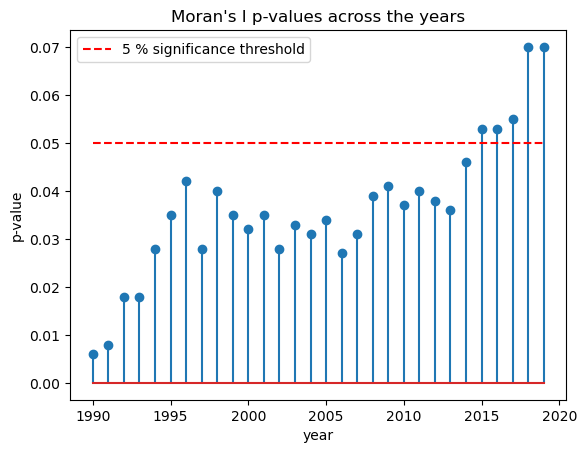

In [29]:
plt.stem(range(1990, 2020), moran_p_values_by_year)
plt.hlines(y=0.05, xmin=1990, xmax=2019, colors='red', linestyles="dashed", label="5 % significance threshold")
plt.xlabel('year')
plt.ylabel('p-value')
plt.title(f"Moran's I p-values across the years")
plt.legend()
plt.show()

The Moran's I values represent the degree of spatial autocorrelation of new HIV cases across different countries in Africa for each year. 

It appears that the Moran's I values are decreasing over time, which suggests that the spatial autocorrelation of new HIV cases is decreasing. In other words, new HIV cases are becoming less spatially clustered and more randomly distributed across different countries in Africa over time.

From the p-values associated with each Moran's I value, it appears that the spatial autocorrelation is statistically significant for all years up to 2014 (p-value < 0.05). However, starting from 2015, the p-values are greater than 0.05, suggesting that the spatial autocorrelation is not statistically significant from this year onwards.

This could be due to a variety of factors but it's most likelly because of changes in the disease spread patterns cause by interventions with the intent of reducing the disease spread.

It's important to note that while Moran's I provides a measure of global spatial autocorrelation, it does not provide information about local spatial patterns. For that, the Local Indicators of Spatial Association (LISA) will be used to identify specific areas of significant clustering or dispersion.

In [30]:
def plot_for_year(year):
    f, ax = plt.subplots(1, figsize=(9, 9))
    HIV_data_by_year[year].plot(
        column="New cases",
        cmap="viridis",
        scheme="quantiles",
        k=5,
        edgecolor="white",
        linewidth=0.0,
        alpha=0.75,
        legend=True,
        legend_kwds={"loc": 2},
        ax=ax,
    )

    # Addition of basemap, ethernet connection is required
    # contextily.add_basemap(
    #     ax,
    #     crs=merged_data_gpd_dd_drop.crs,
    #     source=contextily.providers.Esri.WorldTerrain,
    # )
    ax.set_axis_off()
    plt.show()

# Create a slider for years
year_slider = widgets.IntSlider(min=1990, max=2019, step=1, value=1990, description='Year')

widgets.interact(plot_for_year, year=year_slider)

interactive(children=(IntSlider(value=1990, description='Year', max=2019, min=1990), Output()), _dom_classes=(…

<function __main__.plot_for_year(year)>

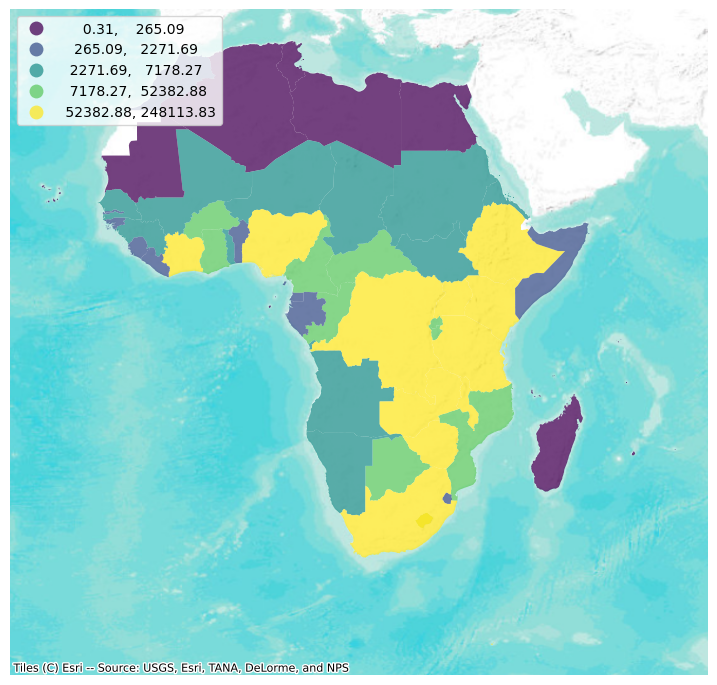

In [31]:
f, ax = plt.subplots(1, figsize=(9, 9))
HIV_data_by_year[1990].plot(
    column="New cases",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)

# Addition of basemap, ethernet connection is required
contextily.add_basemap(
    ax,
    crs=merged_data_gpd_dd_drop.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax.set_axis_off()

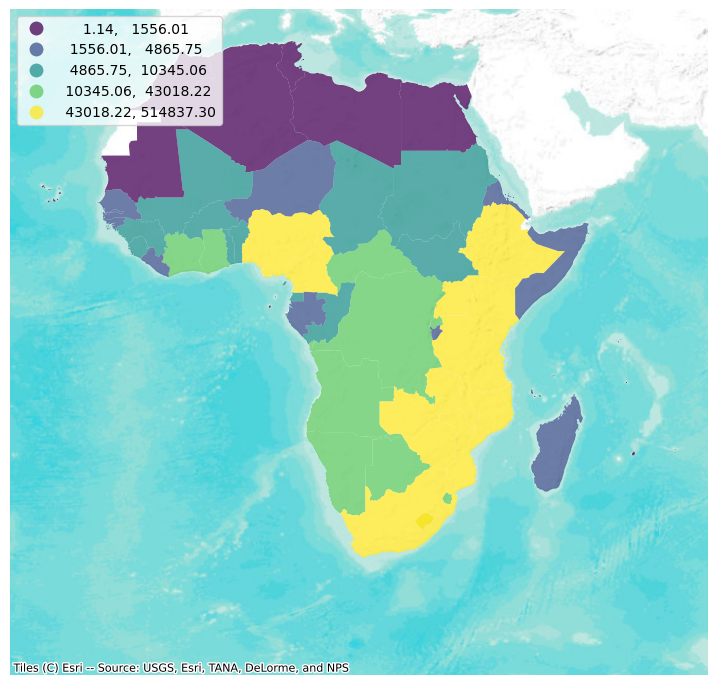

In [32]:
f, ax = plt.subplots(1, figsize=(9, 9))
HIV_data_by_year[2010].plot(
    column="New cases",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)

# Addition of basemap, ethernet connection is required
contextily.add_basemap(
    ax,
    crs=merged_data_gpd_dd_drop.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax.set_axis_off()

In [33]:
# Define a significance level for the p-values
alpha = 0.05

# Create a dictionary to store significant countries for each year
local_significant_countries = {}

# Assuming HIV_data_by_year is your dictionary with year as key
for year, df in HIV_data_by_year.items():
    y = df['New_cases_std'].values
    w = w_Queen_mod # your spatial weights matrix
    lisa = Moran_Local(y, w)
    
    # lisa.Is is an array of local Moran's I values
    df.loc[:,'lisa_values'] = lisa.Is
    # lisa.p_sim is an array of p-values from the simulation
    df.loc[:,'p_values'] = lisa.p_sim

    # Identify countries with significant local spatial autocorrelation
    significant_countries = df[df['p_values'] < alpha]
    
    # Store the significant countries for this year in the dictionary
    local_significant_countries[year] = significant_countries['Entity'].tolist()

local_significant_countries[1990]


['algeria',
 'burundi',
 'cape verde',
 'comoros',
 'kenya',
 'libya',
 'madagascar',
 'malawi',
 'mauritius',
 'mozambique',
 'rwanda',
 'sao tome and principe',
 'senegal',
 'seychelles',
 'somalia',
 'south sudan',
 'tunisia',
 'uganda',
 'tanzania',
 'zambia']

In [34]:
num_significant_countries = {year: len(countries) for year, countries in local_significant_countries.items()}

for year, num in num_significant_countries.items():
    print(f"The number of significant countries in the year {year} is {num}.")

The number of significant countries in the year 1990 is 20.
The number of significant countries in the year 1991 is 19.
The number of significant countries in the year 1992 is 20.
The number of significant countries in the year 1993 is 22.
The number of significant countries in the year 1994 is 22.
The number of significant countries in the year 1995 is 19.
The number of significant countries in the year 1996 is 17.
The number of significant countries in the year 1997 is 17.
The number of significant countries in the year 1998 is 18.
The number of significant countries in the year 1999 is 17.
The number of significant countries in the year 2000 is 16.
The number of significant countries in the year 2001 is 17.
The number of significant countries in the year 2002 is 15.
The number of significant countries in the year 2003 is 17.
The number of significant countries in the year 2004 is 16.
The number of significant countries in the year 2005 is 15.
The number of significant countries in t

Creating a graphical representation

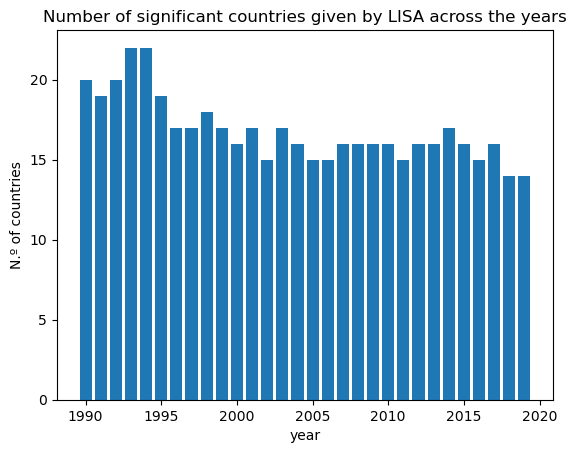

In [35]:
plt.bar(num_significant_countries.keys(), num_significant_countries.values())
plt.xlabel('year')
plt.ylabel('N.º of countries')
plt.title(f"Number of significant countries given by LISA across the years")
plt.show()

In [36]:
def plot_for_year(year):
    # calculate Moran_Local and plot
    lisa = Moran_Local(HIV_data_by_year[year]['New cases'], w_Queen)
    lisa_cluster(lisa, HIV_data_by_year[year], p=0.05, figsize = (9,9))
    plt.show()

# Create a slider for years
year_slider = widgets.IntSlider(min=1990, max=2019, step=1, value=1990, description='Year')

widgets.interact(plot_for_year, year=year_slider)



interactive(children=(IntSlider(value=1990, description='Year', max=2019, min=1990), Output()), _dom_classes=(…

<function __main__.plot_for_year(year)>

The Local Indicators of Spatial Association (LISA) results provide a more granular view of the spatial autocorrelation of new HIV cases across different countries in Africa. While global Moran's I gives an overall measure of spatial autocorrelation, LISA identifies specific areas (countries in this case) where significant spatial autocorrelation is observed.

From the LISA results, it appears that the number of countries with significant local spatial autocorrelation decreases over time. This suggests that fewer countries are part of significant "hot spots" or "cold spots" for new HIV cases.

However, even though the global Moran's I is not statistically significant from 2015 onwards, the LISA results show that there are still some countries each year with significant local spatial autocorrelation. This indicates that while the overall trend is towards less spatial clustering, there are still specific areas where new HIV cases are significantly clustered.

This information could be valuable for public health planning and resource allocation. Areas with significant local spatial autocorrelation might benefit from targeted interventions or increased resources to prevent the spread of HIV.

In summary, the LISA results provide a more detailed picture of the spatial distribution of new HIV cases, highlighting specific areas of significant clustering even when the overall spatial autocorrelation (as measured by Moran's I) is not statistically significant. This underlines the importance of considering both global and local measures of spatial autocorrelation in your analysis. 

But this analysis does not help on detecting and quantifying the spacial relacionships between countries so for that the 2º method is applied.

#### Aplying the 2º. method

As mentioned previously the 2.º method is unable to detect and quantify the spacial relacionships between countries, for that the cross-correlation from the theory of time series is going to be used.

As a title of exemple let's plot the cross-correlation between two countries.

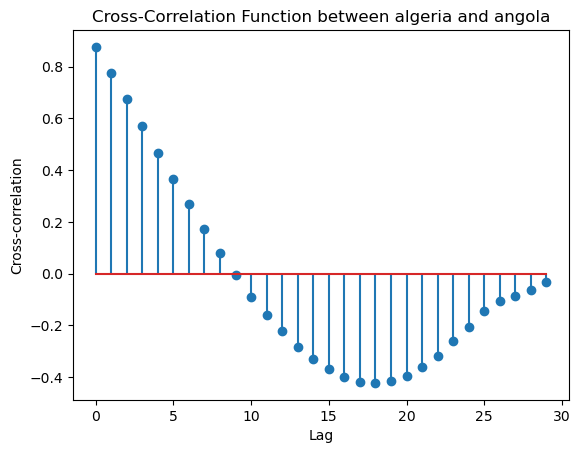

In [37]:
# Extract the 'New cases' column for the first two countries
countries = list(HIV_data_by_country.keys())
first_country_data = HIV_data_by_country[countries[0]]['New cases']
second_country_data = HIV_data_by_country[countries[1]]['New cases']

# Calculate the cross-correlation function with lags
ccf_values = sm.tsa.stattools.ccf(first_country_data, second_country_data, adjusted=False)

# Plot the cross-correlation function
lags = np.arange(len(ccf_values))
plt.stem(lags, ccf_values)
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.title(f'Cross-Correlation Function between {countries[0]} and {countries[1]}')
plt.show()


Now one would need to proceed with the calculation of the confidence intervals for the correlation, so evaluating if the joint distribution of the two variables was normal and then using the appropriate formula, but because of time constraints that analysis was not made. 

The creation of these confidence intervals would enable the test if the correlation was significant or not, thus indicating on the resulting graph possible changes to make for two vertices that were not significant correlated improving therefore the spacial analysis by reducing the wrongly induced spacial correlation.

In [38]:
# Function to calculate cross-correlation
def calculate_ccf(country1, country2):
    first_country_data = HIV_data_by_country[country1]['New cases']
    second_country_data = HIV_data_by_country[country2]['New cases']
    ccf_values = sm.tsa.stattools.ccf(first_country_data, second_country_data, adjusted=False)
    return ccf_values

# Get all unique pairs of countries (upper triangular matrix of combinations)
country_pairs = list(combinations(HIV_data_by_country.keys(), 2))

# Dictionary to store cross-correlation results
ccf_results = {}

# Calculate cross-correlation for each pair
for country1, country2 in country_pairs:
    ccf_results[(country1, country2)] = calculate_ccf(country1, country2)

# Now ccf_results contains the cross-correlation values for each unique pair


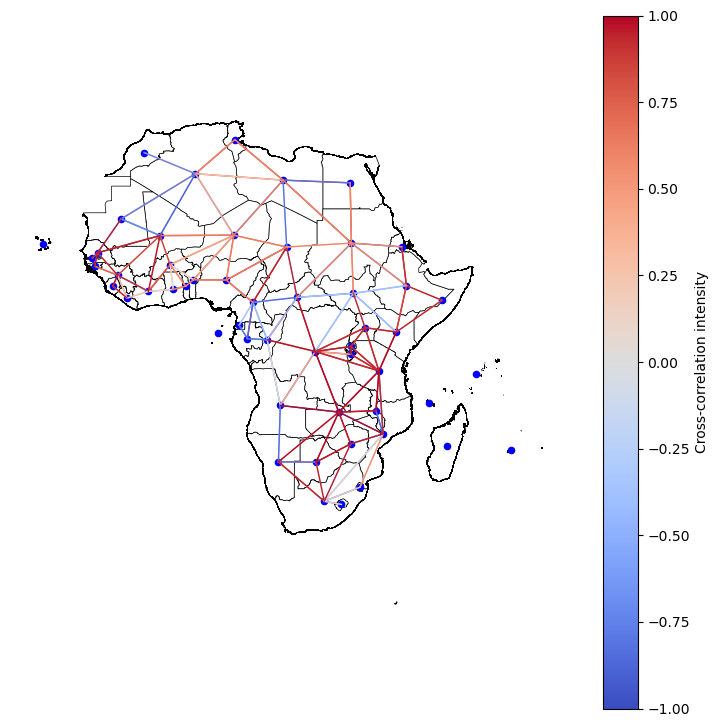

In [39]:
# Function to calculate cross-correlation
def calculate_ccf(country1, country2, HIV_data_by_country):
    first_country_data = HIV_data_by_country[country1]['New cases']
    second_country_data = HIV_data_by_country[country2]['New cases']
    ccf_values = sm.tsa.stattools.ccf(first_country_data, second_country_data, adjusted=False)
    return ccf_values[0]  # Return only the first value of the cross-correlation

# Get all unique pairs of countries (upper triangular matrix of combinations)
country_pairs = list(combinations(HIV_data_by_country.keys(), 2))

# Dictionary to store the first value of cross-correlation results
ccf_first_values = {}

# Calculate the first value of cross-correlation for each pair
for country1, country2 in country_pairs:
    ccf_first_values[(country1, country2)] = calculate_ccf(country1, country2, HIV_data_by_country)

# Plot the geometries without coloring by 'New cases'
f, ax = plt.subplots(1, figsize=(9, 9))
merged_data_gpd_dd_drop.plot(
    color='white', 
    edgecolor='black', 
    linewidth=0.5, 
    ax=ax
)

# Create a colormap for the intensity of the cross-correlation
cmap = plt.get_cmap('coolwarm')

# Normalize the cross-correlation values for coloring
norm = plt.Normalize(-1, 1)

# Overlay the graph of neighbors with vertices and edges
for index, neighbors in w_Queen_mod.neighbors.items():
    country_geometry = merged_data_gpd_dd_drop.geometry.iloc[index]
    country_centroid = country_geometry.centroid.coords[0]
    
    # Plot the vertex for the country
    plt.scatter(*country_centroid, color='blue', s=20)  # s is the size of the vertex
    
    for neighbor_index in neighbors:
        neighbor_geometry = merged_data_gpd_dd_drop.geometry.iloc[neighbor_index]
        neighbor_centroid = neighbor_geometry.centroid.coords[0]
        
        # Get the first value of cross-correlation for the pair
        country = unique_countries[index]
        neighbor_country = unique_countries[neighbor_index]

        try:
            ccf_value = ccf_first_values[(country, neighbor_country)] 
        except KeyError:
            ccf_first_values[(neighbor_country, country)]
        
        # Draw an edge between country centroid and neighbor centroid with color based on ccf_value
        plt.plot(
            [country_centroid[0], neighbor_centroid[0]], 
            [country_centroid[1], neighbor_centroid[1]], 
            color=cmap(norm(ccf_value)), 
            linewidth=1
        )
        
        # Plot the vertex for the neighbor
        plt.scatter(*neighbor_centroid, color='blue', s=10)

ax.set_axis_off()

# Add a colorbar to the plot to show the gradient of cross-correlation intensity
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, orientation='vertical', label='Cross-correlation intensity')

# Show the plot
plt.show()


The resulting graph has similarities with the LISA plot, for instance on the southeast part of Africa there is a very positive correlation between neighbouring countries, also clusters of positive clustering may be observed in the north and on the west of Africa.

# Conclusion

It was observed that the graph representation resulting from the calculation of cross-correlations partially coincides with the results obtained from the LISA analysis. Furthermore, it is noted that this representation can be useful for verifying the validity and even improving the definition of the neighbouring matrix.

Possible improvements and caveats on this work were already stated on the postscript text.